# Proyek *Machine Learning* (*Image Classification*): **Rock Paper Scissors Dataset**
- Nama: Azel Rizki Nasution
- Email: azel.rizki.nasution-2021@ftmm.unair.ac.id
- Username Dicoding: azelrizkinasution

# 1. **LIBRARIES**

In [58]:
from google.colab import drive
import zipfile
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from google.colab import files
import matplotlib.image as mpimg

from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# 2. **DATA PREPROCESSING**

In [2]:
drive.mount('/content/drive')

# Lokasi file zip yang diupload
zip_path = '/content/drive/MyDrive/rockpaperscissors.zip'

# Ekstrak isi file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(".")

Mounted at /content/drive


In [3]:
# Parameter yang perlu disesuaikan
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
NUM_CLASSES = 3  # Sesuaikan dengan jumlah kelas dalam dataset
BATCH_SIZE = 32
EPOCHS = 50

In [4]:
# Mencari lokasi folder utama setelah ekstraksi
base_folder = "rockpaperscissors"

# Menyimpan images dan labels ke dalam list
images = []
labels = []

# Looping untuk membaca setiap file dalam subfolder
for folder in os.listdir(base_folder):
    folder_path = os.path.join(base_folder, folder)
    if os.path.isdir(folder_path):
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            image = Image.open(image_path).convert('RGB')
            image = np.asarray(image.resize((IMAGE_WIDTH, IMAGE_HEIGHT)))
            image = image / 255.0  # Normalisasi
            images.append(image)
            labels.append(folder)  # Folder name as label

# Menampilkan jumlah gambar dan label
len_images = len(images)
len_labels = len(labels)

print(f'images length: {len_images}')
print(f'labels length: {len_labels}')

images length: 2188
labels length: 2188


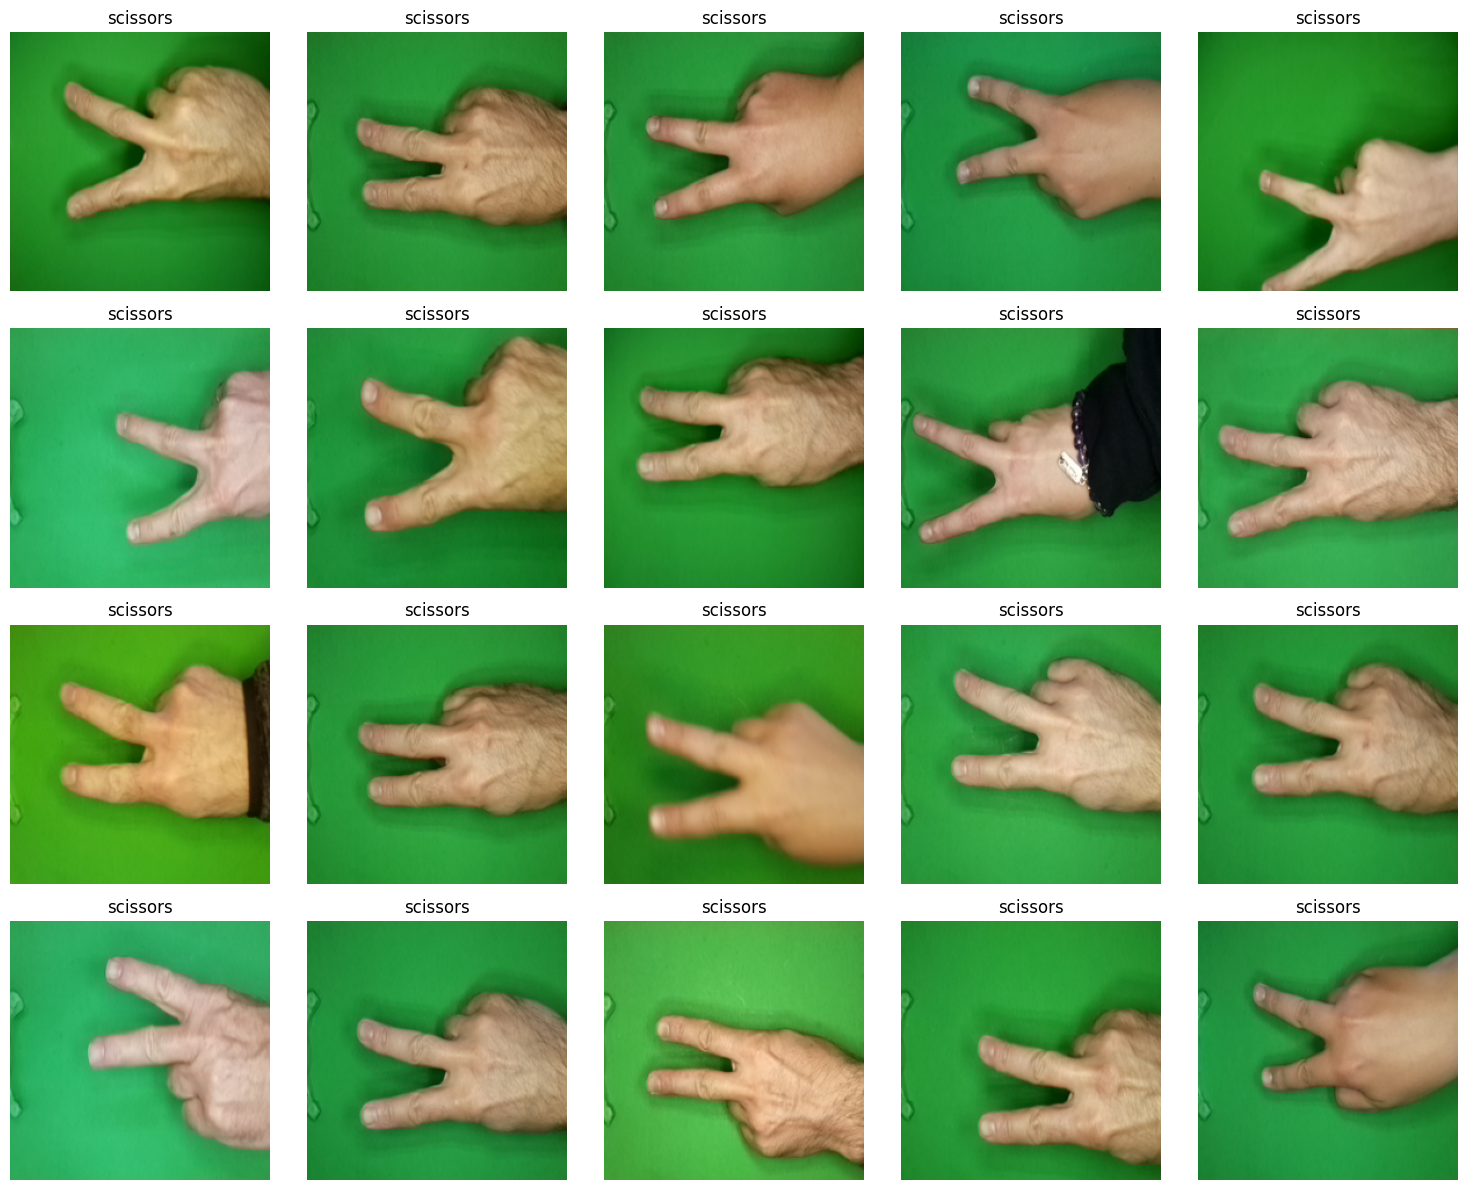

In [5]:
def display_sample_images(images, labels, num_images):
    if num_images > len(images):
        print("Jumlah gambar yang diminta melebihi jumlah gambar dalam dataset")
        return

    selected_images = images[:num_images]
    selected_labels = labels[:num_images]

    # Hitung jumlah baris yang dibutuhkan untuk menampilkan semua gambar
    num_rows = num_images // 5 + int(num_images % 5 != 0)

    # Menyiapkan plot
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
    axes = axes.ravel()

    for i in range(num_rows * 5):
        if i < num_images:
            axes[i].imshow(selected_images[i])
            axes[i].set_title(selected_labels[i])
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Contoh pemanggilan fungsi
display_sample_images(images, labels, 20)


In [6]:
uniquelabel = np.unique(labels)

label_to_int = {}  # Create a dictionary to map labels to integers

for i in range(len(uniquelabel)):
    replace = uniquelabel[i]
    label_to_int[replace] = i

print(label_to_int)

# Now, map the labels to integers using the dictionary
labels_as_int = [label_to_int[label] for label in labels]

{'paper': 0, 'rock': 1, 'scissors': 2}


In [7]:
one_hot_labels = to_categorical(labels_as_int, NUM_CLASSES)
print(one_hot_labels)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [8]:
images=np.array(images)
labels=np.array(one_hot_labels)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=42)

# Mengecek shape/bentuk data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1312, 224, 224, 3)
(876, 224, 224, 3)
(1312, 3)
(876, 3)


In [9]:
# Data augmentation untuk training set
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range=0.1,
                                   fill_mode="nearest"
                                   )

# Hanya rescale untuk validation set
val_datagen = ImageDataGenerator()

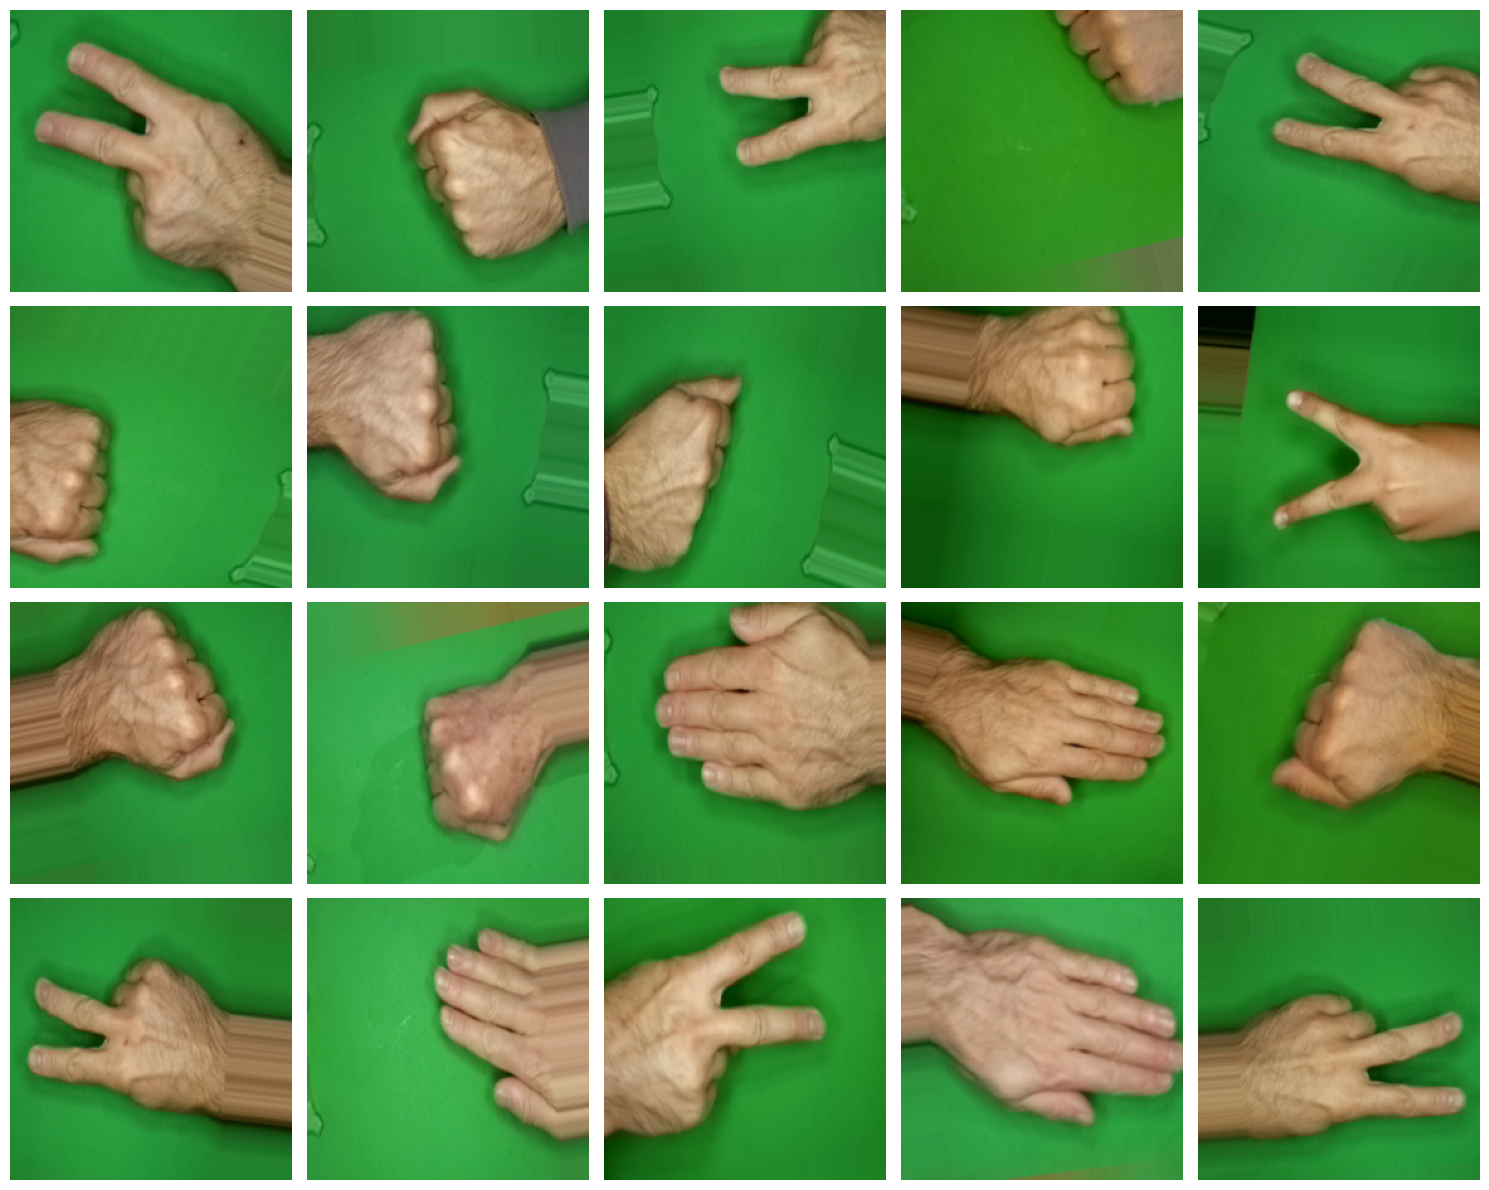

In [10]:
def display_augmented_images_first_set(original_images, augmentor, num_images=20):
    if num_images > len(original_images):
        print("Jumlah gambar yang diminta melebihi jumlah gambar dalam dataset")
        return

    # Hitung jumlah baris yang dibutuhkan untuk menampilkan semua gambar
    num_rows = num_images // 5 + int(num_images % 5 != 0)

    # Menyiapkan plot
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
    axes = axes.ravel()

    for i in range(num_rows * 5):
        if i < num_images:
            # Gambar yang telah diubah (augmented)
            augmented_image = next(augmentor.flow(np.expand_dims(original_images[i], 0)))[0]
            axes[i].imshow(augmented_image)
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Contoh pemanggilan fungsi
display_augmented_images_first_set(X_train, train_datagen, num_images=20)


In [11]:
# Flow data train dan data validation
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE
)

validation_generator = val_datagen.flow(
    X_test, y_test,
    batch_size=BATCH_SIZE
)

# 3. **IMAGE CLASSIFICATION**

In [14]:
model = Sequential()

# Layer convolution dan max pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten dan Dense layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))  # Output layer

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)]

# Menampilkan summary model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [15]:
# Melatih model dengan data training dan validasi
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(X_test) // BATCH_SIZE,
    callbacks=callbacks
)


Epoch 1/50
41/41 [==============================] - 31s 456ms/step - loss: 1.2354 - accuracy: 0.3841 - val_loss: 1.0465 - val_accuracy: 0.4653 - lr: 0.0010
Epoch 2/50
41/41 [==============================] - 18s 446ms/step - loss: 1.0174 - accuracy: 0.4710 - val_loss: 0.9537 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 3/50
41/41 [==============================] - 19s 458ms/step - loss: 0.8929 - accuracy: 0.6075 - val_loss: 0.6495 - val_accuracy: 0.8634 - lr: 0.0010
Epoch 4/50
41/41 [==============================] - 19s 456ms/step - loss: 0.5334 - accuracy: 0.7896 - val_loss: 0.2098 - val_accuracy: 0.9549 - lr: 0.0010
Epoch 5/50
41/41 [==============================] - 18s 448ms/step - loss: 0.2928 - accuracy: 0.8986 - val_loss: 0.1183 - val_accuracy: 0.9757 - lr: 0.0010
Epoch 6/50
41/41 [==============================] - 18s 442ms/step - loss: 0.2406 - accuracy: 0.9245 - val_loss: 0.0711 - val_accuracy: 0.9861 - lr: 0.0010
Epoch 7/50
41/41 [==============================] - 18s 447ms/st

# 4. **MODEL EVALUATION**

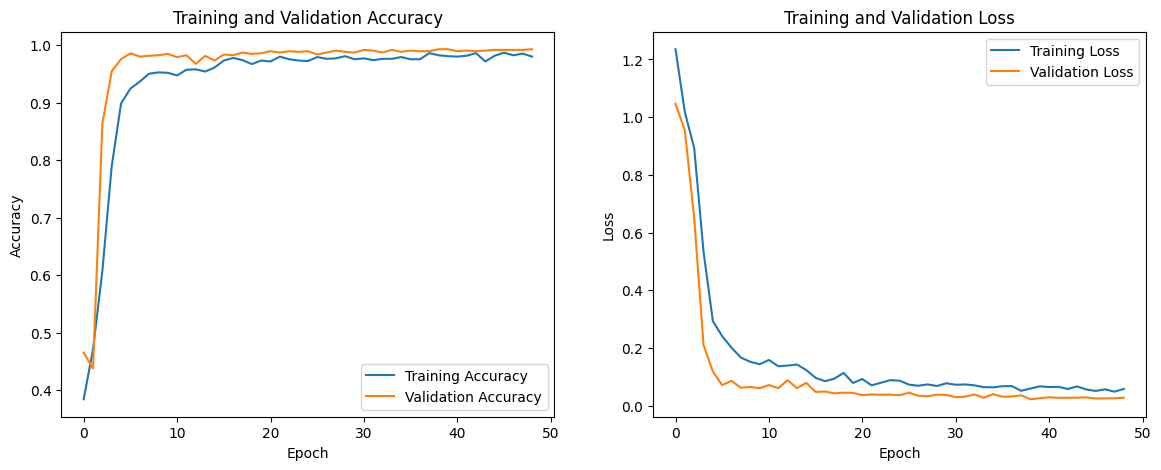

In [59]:
# Mendapatkan data historis dari proses pelatihan
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot akurasi pelatihan dan validasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# Plot training loss dan training validation
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [24]:
# Melakukan klasifikasi pada data uji
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Menghitung laporan klasifikasi
print(classification_report(y_true, y_pred_classes))


28/28 [==============================] - 1s 30ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       278
           1       1.00      1.00      1.00       289
           2       0.99      1.00      0.99       309

    accuracy                           0.99       876
   macro avg       0.99      0.99      0.99       876
weighted avg       0.99      0.99      0.99       876



# 5. **PREDICT IMAGES**

Saving K06meJWsLavqjfyX.png to K06meJWsLavqjfyX.png
Saving k7KXWWd1IymDhMIm.png to k7KXWWd1IymDhMIm.png
Saving KAXMiWZQIm1n1Hji.png to KAXMiWZQIm1n1Hji.png
Saving kC1AoCFrvaMKlTDk.png to kC1AoCFrvaMKlTDk.png
Saving KcCGOFZoEMOitVPh.png to KcCGOFZoEMOitVPh.png
Saving Mq8Ym2axOJVIthiP.png to Mq8Ym2axOJVIthiP.png
Saving mugG8B1m5Ra2aRgZ.png to mugG8B1m5Ra2aRgZ.png
Saving mUqkjFi6NBsHR7tf.png to mUqkjFi6NBsHR7tf.png
Saving Mv6oOH192gse3oZA.png to Mv6oOH192gse3oZA.png
Saving mV9vc1ITH1PrrbF8.png to mV9vc1ITH1PrrbF8.png
Saving QKlibCXvATAv2H4i.png to QKlibCXvATAv2H4i.png
Saving qKPJSQplDj0grFPp.png to qKPJSQplDj0grFPp.png
Saving Qm3EaazkLKL9qJJz.png to Qm3EaazkLKL9qJJz.png
Saving QM8un28uGzplAkrb.png to QM8un28uGzplAkrb.png
Saving qMWVb6BibNukvVrj.png to qMWVb6BibNukvVrj.png
1/1 [==============================] - 0s 18ms/step


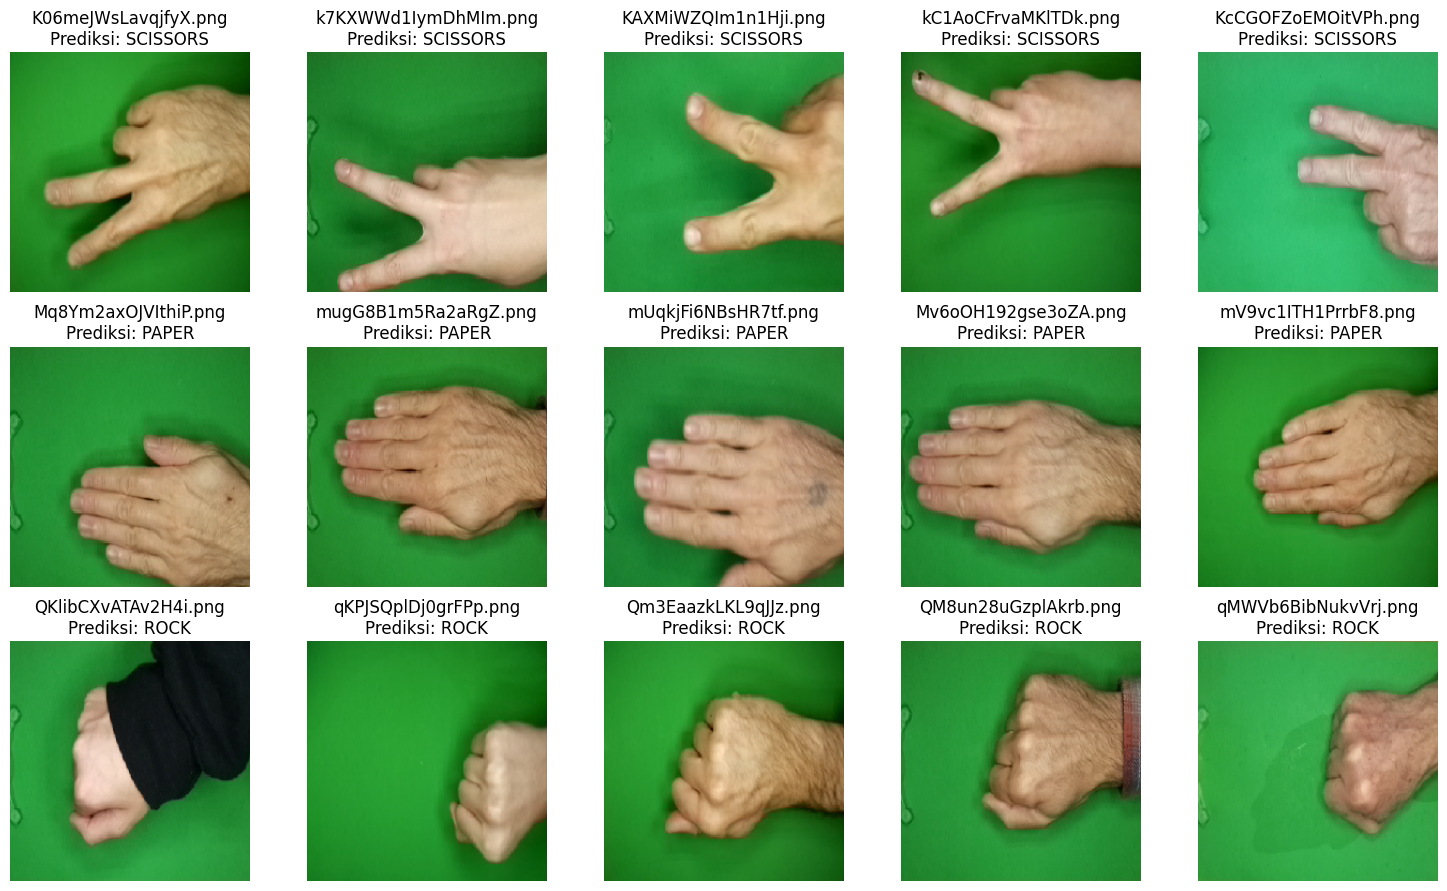

In [57]:
def upload_and_predict(num_images):
    uploaded = files.upload()

    num_uploaded = len(uploaded.keys())
    num_rows = num_uploaded // 5 + int(num_uploaded % 5 != 0)

    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
    axes = axes.ravel()

    for i, fn in enumerate(uploaded.keys()):
        if i >= num_images:
            break

        # Memproses gambar
        path = fn
        img = image.load_img(path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0) / 255.0

        # Prediksi
        classes = model.predict(x)
        predicted_class = np.argmax(classes, axis=1)

        # Menentukan label kelas
        label = 'PAPER' if predicted_class[0] == 0 else 'ROCK' if predicted_class[0] == 1 else 'SCISSORS'

        # Menampilkan gambar dan hasil prediksi
        axes[i].imshow(img)
        axes[i].set_title(f"{fn}\nPrediksi: {label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Contoh pemanggilan fungsi dengan 15 gambar
upload_and_predict(15)
